In [1]:
!pip install opendatasets

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import opendatasets as od
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from tensorflow.keras.optimizers import AdamW


In [3]:
od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Skipping, found downloaded files in "./brain-tumor-mri-dataset" (use force=True to force download)


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


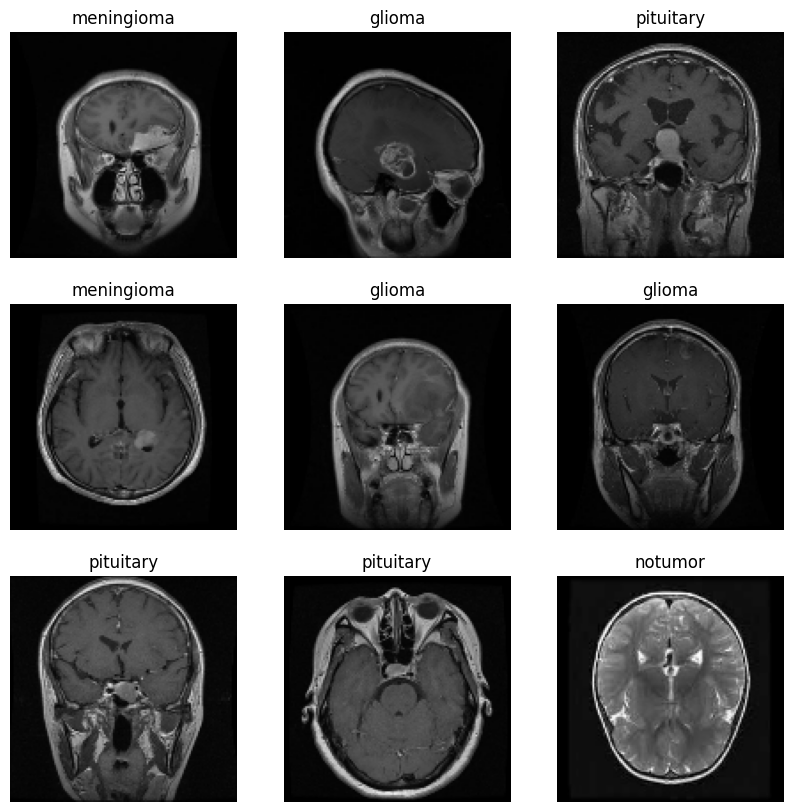

In [11]:

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    "/content/brain-tumor-mri-dataset/Training",
    image_size=(128,128),
    batch_size=32,
    label_mode="categorical" , shuffle = True
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    "/content/brain-tumor-mri-dataset/Testing",
    image_size=(128,128),
    batch_size=32,
    label_mode="categorical",shuffle = False
)

class_names = train_ds_raw.class_names

plt.figure(figsize=(10,10))
for images,labels in train_ds_raw.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_index = labels[i].numpy().argmax()
    plt.title(class_names[label_index])
    plt.axis("off")


normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x,y: (normalization_layer(x),y))
test_ds  = test_ds_raw.map(lambda x,y: (normalization_layer(x),y))


In [12]:
model = models.Sequential([
    layers.Conv2D(32,(3,3),activation="relu",input_shape=(128,128,3),padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu",padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation="relu",padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(4,activation="softmax")

])
model.compile(optimizer=AdamW(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
early_s = EarlyStopping(monitor='val_loss', patience=15, verbose=1,restore_best_weights=True)
history = model.fit(train_ds,epochs=500,validation_data=test_ds,callbacks=[early_s])

Epoch 1/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.5979 - loss: 0.9856 - val_accuracy: 0.7597 - val_loss: 0.5698
Epoch 2/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8231 - loss: 0.4725 - val_accuracy: 0.8093 - val_loss: 0.4400
Epoch 3/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8668 - loss: 0.3488 - val_accuracy: 0.8566 - val_loss: 0.3301
Epoch 4/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9000 - loss: 0.2623 - val_accuracy: 0.9092 - val_loss: 0.2223
Epoch 5/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9159 - loss: 0.2184 - val_accuracy: 0.9108 - val_loss: 0.2194
Epoch 6/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9362 - loss: 0.1730 - val_accuracy: 0.9390 - val_loss: 0.1565
Epoch 7/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9470 - loss: 0.1393 - val_accuracy: 0.9489 - val_loss: 0.1377
Epoch 8/500
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9612 - loss: 0.1000 

In [18]:
loss,acc = model.evaluate(test_ds)
print("Loss: ",loss)
print("Accuracy: ",acc)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9601 - loss: 0.1469
Loss:  0.09900305420160294
Accuracy:  0.9733028411865234


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


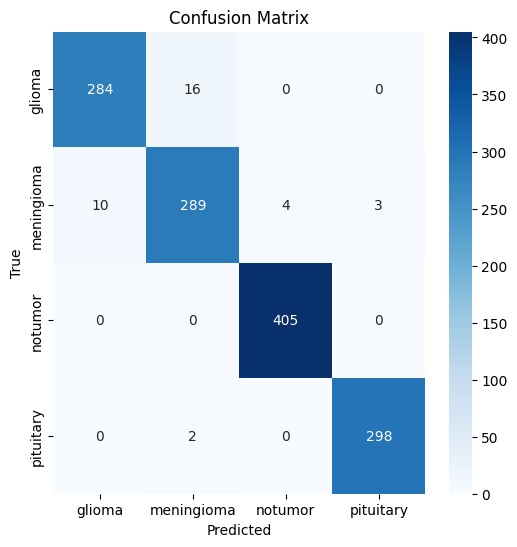

              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       300
  meningioma       0.94      0.94      0.94       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [19]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()


print(classification_report(y_true, y_pred, target_names=class_names))

In [23]:
model.save("brain_tumor_multiclass_cnn.h5")
from google.colab import files
files.download("brain_tumor_multiclass_cnn.h5")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
requirements = """streamlit
tensorflow
numpy
pillow
seaborn
scikit-learn
matplotlib
pandas
"""

with open("requirements.txt", "w") as f:
    f.write(requirements)
from google.colab import files
files.download("requirements.txt")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>